## Introduction

>
>
>
>
>

Hi, and welcome to our CIS 545 Project! 

Our group members are :
- Kelly Liang
- Henry Hung
- Kun Hwi Ko

Today, we are here to do the following :

* Step 1 : Navigate through a movies dataset, and clean for necessary data 
* Step 2 : Visualize the data to get initial insights 
* Step 3 : Reformat the data to be compatible for machine learning 
* Step 4 : Use K-Means Clustering to forecast what movies users will like  

## Packages / Setup

In [ ]:
%%capture 

# data cleaning and visualization packages 
!pip install pandasql
import collections 
import numpy as np 
import pandas as pd
import pandasql as ps 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns  
import collections
import itertools

# machine learning packages 
from sklearn.cluster import KMeans


In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# Step 1 : install dependencies 
!pip install -q kaggle 

# Step 2 : create API Token from Kaggle and upload Kaggle.json 
# Instructions : https://www.kaggle.com/general/74235
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kellyhuilinliang","key":"1122b3285bf559c6a2494083ddeada0a"}'}

In [ ]:
# Step 3: additional steps 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4 : download the dataset 
# https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

# Step 5 : Unzip the files 
!unzip the-movies-dataset.zip

 95% 217M/228M [00:07<00:00, 29.0MB/s]
100% 228M/228M [00:07<00:00, 29.9MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


## Data Cleansing

In [ ]:
# retrieve Kaggle data 

ratings_df = pd.read_csv("/content/ratings.csv")
keywords_df = pd.read_csv("/content/keywords.csv")
movies_df = pd.read_csv("/content/movies_metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's start by cleansing the keywords, movies, and rating dataframe.

In [ ]:
# cleansing keywords

# Step 1 : get rid of rows without any keywords 
keywords_df = keywords_df[keywords_df['keywords'] != '[]']

# Step 2 : convert str --> [array of words]
def str_parser(strs):
  res = re.findall("name': '(.*?)'", strs)
  return res if res else None 

keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str_parser(x))
keywords_df.dropna(inplace=True)

In [ ]:
# cleansing movies

# Step 1 : drop unnecessary columns 
movies_df.drop(columns = ['adult', 'belongs_to_collection', 'budget', 'homepage', \
                          'imdb_id', 'original_language', 'original_title', 'overview', \
                          'poster_path', 'production_countries', 'release_date', 'revenue', \
                          'runtime', 'spoken_languages', 'status', 'tagline', 'video'], inplace = True)

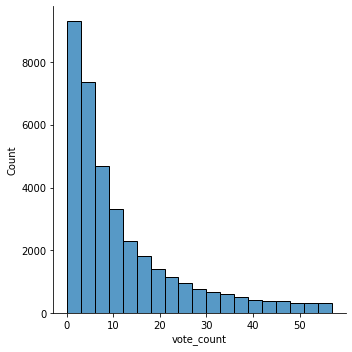

In [ ]:
# Step 2: drop movies that not many people have watched as it can create bias 
sns.displot(movies_df, x = "vote_count", bins = [i for i in range(0, 60, 3)])
vote_threshold = 3
movies_df = movies_df[movies_df['vote_count'] >= vote_threshold]

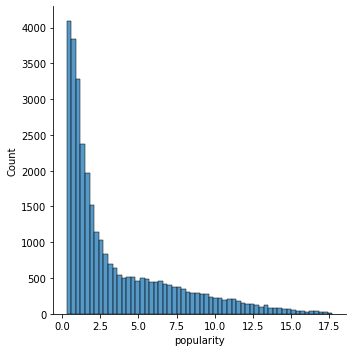

In [ ]:
# Step 3: drop non-popular movies as they will likely not be recommended
movies_df['popularity'] = movies_df['popularity'].apply(lambda x : float(x))
sns.displot(movies_df, x = "popularity", bins = [i*0.3 for i in range(1, 60)])
popular_threshold = 0.6
movies_df = movies_df[movies_df['popularity'] >= popular_threshold]

In [ ]:
# Step 4 : convert str --> [array of words]
movies_df['genres'] = movies_df['genres'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

Now that movies and keywords have been cleaned, let's join the two together. 

In [ ]:
# join movies_df and keywords_df 
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str(x))
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str(x)) 

query = '''
select m.id, title, 
production_companies, genres,
keywords, popularity, 
vote_average, vote_count
from movies_df as m
join keywords_df as k
on m.id = k.id
'''

movies_df = ps.sqldf(query, locals())

In [ ]:
# cleansing ratings 

# Step 1 : ratings_df is a very large dataset sorted by userId 
# we do not need to use all of the users as part of training 
ratings_df = ratings_df[ratings_df['userId'] <= 10000]

# Step 2 : drop unnecessary columns 
ratings_df.drop(columns = ['timestamp'], inplace=True) 

In [ ]:
# Step 3 : get rid of ratings for movies not in movies_df 
movies_df['id'] = movies_df['id'].apply(lambda x : int(x))
ratings_df['movieId'] = ratings_df['movieId'].apply(lambda x : int(x))

query = '''
select * 
from ratings_df 
where movieId in (
  select id 
  from movies_df
)
'''

ratings_df = ps.sqldf(query, locals())

In [ ]:
# Step 4 : get rid of movies not rated in ratings_df 
query = '''
select * 
from movies_df 
where id in (
  select movieId 
  from ratings_df
)
'''

movies_df = ps.sqldf(query, locals())

In [ ]:
# Finally convert columns to how we want them 
movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

In [ ]:
# Make sure we have enough unique users before continuing
query = '''
select userId, count(movieId)
from ratings_df
group by userId
'''

ps.sqldf(query, locals()).shape

(9779, 2)

## Data Exploration & Visualization


### **Popular movie producers**
Is it safe to assume that non-popular production companies didn't make any popular movies? Let's find out. 

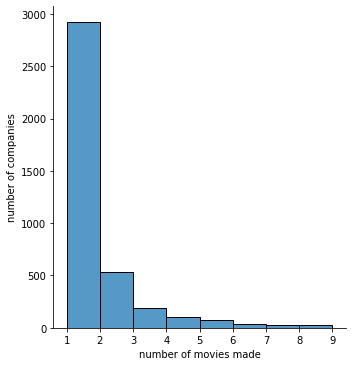

In [ ]:
companies = [company for companies in movies_df['production_companies'] for company in companies]
freq = collections.Counter(companies)

ax = sns.displot(freq, x = freq.values(), bins = [i for i in range(1, 10)])
ax.set(xlabel='number of movies made', ylabel='number of companies')

From the plot above, we can tell there are a lot of companies that have made just 1 movie.

Now let's check if any of these companies have produced a movie that turned out to be a success.

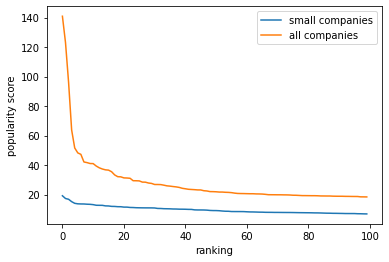

In [ ]:
large_companies = {k for k,v in freq.items() if v > 1}
number_of_rows = movies_df.count()[0]

popularity_by_small_companies = []
popularity_by_all_companies = []

for i in range(number_of_rows):
  small = True 
  for company in movies_df['production_companies'].iloc[i]:
    if company in large_companies:
      small = False 
      break 
  if small:
    popularity_by_small_companies.append(movies_df['popularity'].iloc[i])
   
plt.plot(sorted(popularity_by_small_companies, reverse=True)[:100], label='small companies')  
plt.plot(sorted(movies_df['popularity'], reverse=True)[:100], label='all companies') 
plt.xlabel('ranking'); plt.ylabel('popularity score')
plt.legend()

It appears small companies never made any movies that are within the top 100 popular movies.

However, looking at our graph, it appears that starting from the 40th most popular movie, there really isn't a large discrepency that proves small companies make only non-popular movies. 

Therefore, we can disregard production companies as a factor for recommending movies. 


In [ ]:
movies_df.drop(columns = ['production_companies'], inplace=True)

### **Genres & Individual User Rating**

So now let's look at the genre column.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'count')

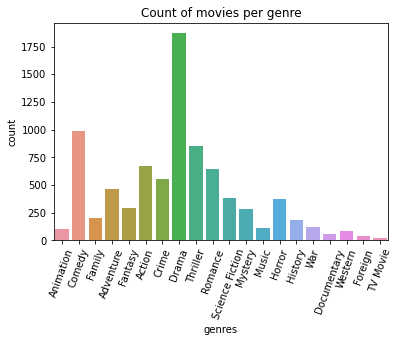

In [ ]:
all_genres = {}

for i in range(number_of_rows):
  for genre in movies_df['genres'].iloc[i]:
    all_genres[genre] = all_genres.get(genre, 0) + 1

sns.barplot(list(all_genres.keys()), list(all_genres.values()))
plt.xticks(rotation=70)

plt.title("Count of movies per genre")
plt.xlabel('genres')
plt.ylabel('count')  

It appears that there are a total of 20 genres.

The most popular genre is 'Drama', and the least popular is 'Foreign'. 

So let's discover how each user in ratings_df rates each category based on the movies they rated. 

In [ ]:
# Step 1 : create a copy of ratings_df and merge genres from movies_df
genres_df = ratings_df.copy(deep=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select *
from genres_df as g
join movies_df as m
on m.id = g.movieId 
'''

genres_df = ps.sqldf(query, locals())
genres_df.drop(columns=['id', 'keywords', 'popularity',\
                        'vote_average', 'vote_count',\
                        'movieId', 'title'], inplace=True)
genres_df.sort_values(by=['userId'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
genres_df['genres'] = genres_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 

In [ ]:
# Step 2 : append all the genres as columns 
number_of_rows = genres_df.count()[0]

for genre in all_genres.keys():
  genres_df[genre] = [0 for _ in range(number_of_rows)]

In [ ]:
# Step 3 : assign scores to the columns 
# we use a bias to help differentiate certain scores from a score of 0

bias = 0.5 
for i in range(number_of_rows):
  genres = genres_df['genres'].iat[i]
  val = genres_df['rating'].iat[i]
  for genre in genres:  
    genres_df[genre].iat[i] += val + bias 

In [ ]:
# This dataframe shows the total sum of the ratings for each genre and for each user
# We later reformat this data for machine learning purposes
genres_df.head()

,userId,rating,genres,Animation,Comedy,Family,Adventure,Fantasy,Action,Crime,Drama,Thriller,Romance,Science Fiction,Mystery,Music,Horror,History,War,Documentary,Western,Foreign,TV Movie
0,1,1.0,"[Drama, Mystery, Romance]",0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
7,1,4.0,[Comedy],0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,4.0,[Comedy],0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,4.5,"[Drama, Crime]",0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,0
8,1,4.0,[Drama],0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0


### **Frequency of Keywords** 

Given the plethora of keywords we are seeing in our dataset, it might be a good idea to see how they are distributed and count how many distinct keywords there are exactly. 

What you will find at the end of this section: 

1) Top 20 most popular keywords 

2) Top 20 least popular keywords (might be affected by alphabetical order)



In [ ]:
#creating copies of movies and ratings for further analyses
movies_copy = movies_df.copy()

In [ ]:
keywords_list = movies_copy.explode("keywords")['keywords'].tolist()

In [ ]:
temp = pd.DataFrame(keywords_list, columns=['keywords'])
temp['frequency'] = 1

# there are a total of 7949 number of keywords from our data
keywords_df = temp.groupby('keywords', as_index=False).count().sort_values('frequency', ascending=False)
keywords_df['frequency'].count()

7949

Text(0.5, 1.0, 'top 20 frequently used keywords')

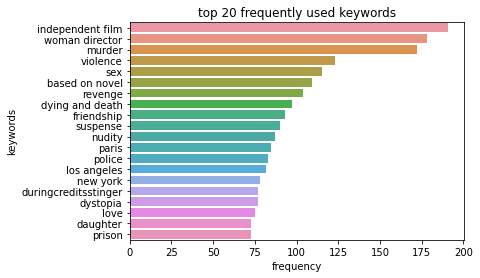

In [ ]:
sns.barplot(y='keywords', x='frequency', data=keywords_df.head(20))
plt.title("top 20 frequently used keywords")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

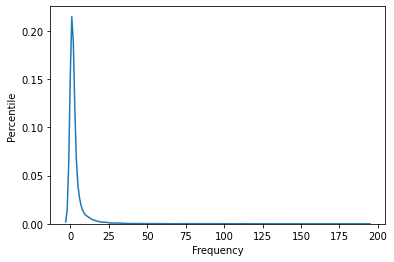

In [ ]:
# with a distribution plot, we can discover that a lot of the keywords
# are associated with only a few movies (highly specific keywords)

# we visualize the distribution here 
ax = sns.distplot(keywords_df['frequency'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

In [ ]:
# in the distribution, there are many highly specific keywords clustered together
# we start by using only 20% of the 'least' specific keywords 

# this brings us to a frequency of 4 keywords per movie 
keywords_df['frequency'].quantile(q=0.8)

4.0

In [ ]:
# there are 6555 keywords that appear less than of equal to 4 times
keywords_df[keywords_df['frequency'] <= 4]['keywords'].count()

6555

In [ ]:
# this generates the list of highly specific keywords
highly_specific_keywords = keywords_df[keywords_df['frequency']<=4]['keywords'].tolist()

In [ ]:
# we will focus on the "not so specific" keywords 
keywords_df = keywords_df[keywords_df['frequency']>4]
keywords = [word.lower() for word in keywords_list if word not in highly_specific_keywords]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

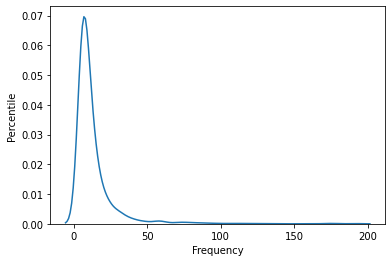

In [ ]:
# visualize the distribution for the new keywords and their frequency
ax = sns.distplot(keywords_df['frequency'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

In [ ]:
# for now we use 1394 keywords  
# in a later section, we will reduce the number of keywords used 
len(keywords_df['frequency'])

1394

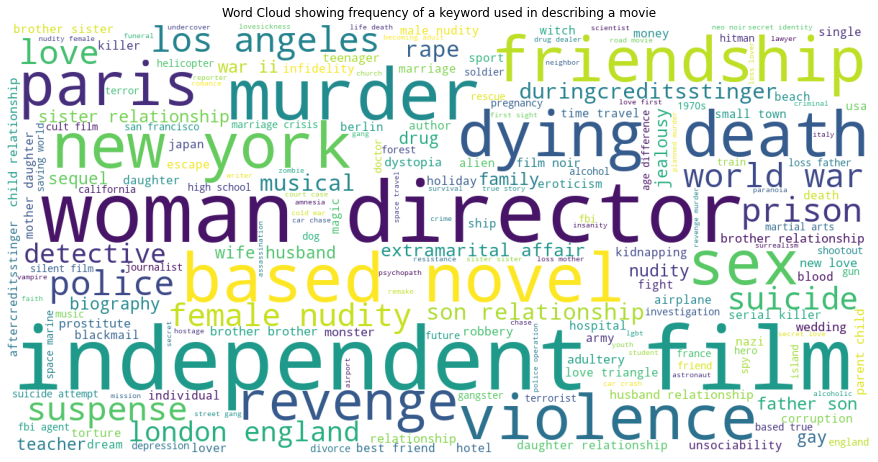

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
    
comment_words = "" + " ".join(keywords) + " "

wordcloud = WordCloud(width = 1200, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.title("Word Cloud showing frequency of a keyword used in describing a movie")
  
plt.show() 

From the above section, we now know the most popular keywords associated with different movies, as well as the least popular keywords. We can use these keywords later on for our machine learning model. 






### **Correlation between Popularity, Vote Count, Vote Average** 

Correlation can potentially be dangerous for statistics and machine learning. Let's try to get rid of as much correlation as possible.

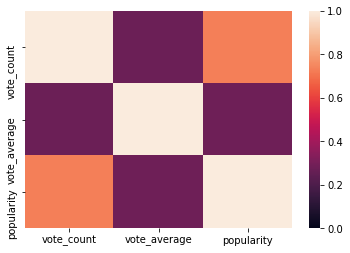

In [ ]:
temp = movies_df[['vote_count','vote_average','popularity']]
sns.heatmap(temp.corr(), vmin=0)

In [ ]:
# it's relatively intuitive to imagine why popularity and vote count are correlated
movies_df.drop(columns=['vote_count'], inplace=True)

It appears that there isn't a strong enough evidence to support that the average rating is correlated with popularity. 

### **Correlation between Frequency and Popularity of Keywords**

Now let's answer : Are frequently-used keywords associated with highly popular movies?

In [ ]:
popular_keywords = movies_df[['keywords', 'popularity']].explode('keywords').reset_index()
popular_keywords = popular_keywords.groupby('keywords', as_index=False)[['keywords', 'popularity']].mean().\
                          sort_values('popularity', ascending=False)

filtered_popular_keywords = popular_keywords[popular_keywords['keywords'].isin(keywords)] 

Text(0.5, 1.0, 'top 20 keywords used to describe popular movies')

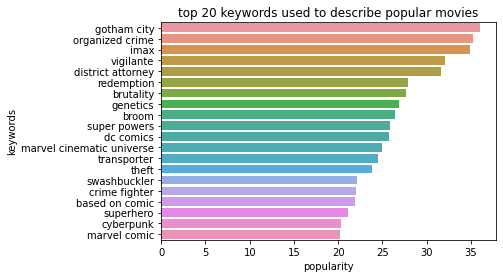

In [ ]:
sns.barplot(y='keywords', x='popularity', data=filtered_popular_keywords.head(20))
plt.title('top 20 keywords used to describe popular movies')

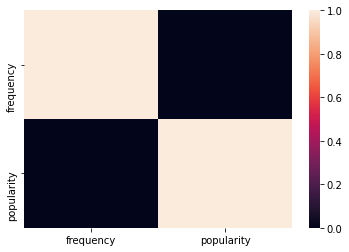

In [ ]:
query = '''
select k.keywords, k.frequency, f.popularity
from keywords_df as k
join filtered_popular_keywords as f
on k.keywords = f.keywords
'''

freq_pop = ps.sqldf(query)
sns.heatmap(freq_pop.corr(), vmin=0)

It appears that there isn't a correlation between frequency and popularity! 

## Towards Machine Learning


### **What now?** 



For our machine learning model, we would like a genres and keywords dataframe that shows the ratings for each genre/keyword based on the movies users have watched. 

We will need to reformat our current genres and keywords dataframe to make it compatible for machine learning. 



### **Reformatting the Genres Dataframe** 

We look for the average rating per genre based on movies each individual has seen. 

In [ ]:
genres_df.drop(columns=['rating','genres'], inplace=True)

query = '''
select userId, avg("Animation") as animation, avg("Comedy") as comedy,
avg("Family") as family, avg("Action") as action, avg("Crime") as crime,
avg("Drama") as drama, avg("Thriller") as thriller, avg("Romance") as romance,
avg("Science Fiction") as science_fiction, avg(Mystery) as mystery, 
avg("Music") as music, avg("Horror") as horror, avg("War") as war, 
avg("Documentary") as documentary, avg("Western") as western,
avg("Foreign") as 'foreign', avg("TV Movie") as tv_movie 
from genres_df
group by userId
'''

genres_df = ps.sqldf(query, locals())
genres_df.head()

,userId,animation,comedy,family,action,crime,drama,thriller,romance,science_fiction,mystery,music,horror,war,documentary,western,foreign,tv_movie
0,1,0.0,1.888889,0.000000,0.000000,0.555556,3.222222,0.000000,1.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0
1,2,0.0,0.823529,0.176471,0.882353,0.176471,1.764706,0.470588,0.705882,0.235294,0.411765,0.058824,0.470588,0.176471,0.0,0.000000,0.00,0.0
2,3,0.0,2.000000,0.000000,0.750000,1.000000,2.125000,0.625000,1.250000,0.375000,0.375000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0
3,4,0.0,0.850000,0.000000,0.700000,0.850000,1.850000,0.550000,0.950000,0.200000,0.350000,0.000000,0.200000,0.000000,0.0,0.500000,0.05,0.0
4,5,0.0,1.111111,0.000000,0.666667,1.111111,3.000000,1.222222,1.111111,1.000000,0.555556,0.000000,0.555556,0.000000,0.0,0.444444,0.00,0.0


### **Reducing Number of Keywords** 


For keywords, this is much less simpler as there are too many keywords. We shorten the number of keywords a bit more than previous. 








In [ ]:
# build a dataframe to explore the number of times a keyword is associated with some genre 
keyword_to_genres = movies_df[['keywords', 'genres']] 
keyword_to_genres = keyword_to_genres.explode('genres').explode('keywords')

In [ ]:
# group by keywords 
# the more genres are associated with a particular keyword, the more generic the keyword is 
temp_df = keyword_to_genres.groupby('keywords', as_index=False).count().sort_values('genres', ascending = False)

Text(0.5, 1.0, 'top 20 generic keywords to describe movies of different genres')

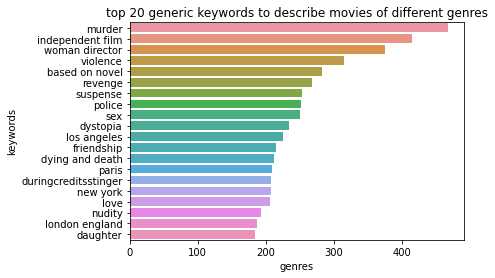

In [ ]:
sns.barplot(y='keywords', x='genres', data=temp_df.head(20))
plt.title("top 20 generic keywords to describe movies of different genres")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

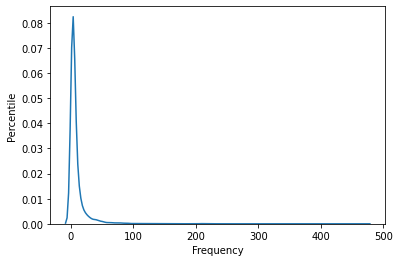

In [ ]:
# we visualize the distribution here 
ax = sns.distplot(temp_df['genres'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

In [ ]:
# let's get rid of 15% of the most generic words 

# this would be a count of more than 13
upper_bound = temp_df['genres'].quantile(q=0.85)
upper_bound

13.0

In [ ]:
# we observe the non-generic words
keywords_to_observe = temp_df[temp_df['genres'] < upper_bound]['keywords'].tolist()

We can focus on the specific keywords so that we are not over-generalising the recommendation system.

Note that generic keywords do not necessarily entail frequent keywords (and vice versa).


In [ ]:
keywords = set(keywords_df['keywords'])

keywords_df = pd.DataFrame([word for word in keywords_to_observe if word in keywords], columns=['keywords'])

In [ ]:
# now we only look at 194 keywords! 
keywords_to_observe = set(keywords_df['keywords'].tolist())
len(keywords_to_observe)

194

In [ ]:
# let's look at the distribution for our non-generic keywords 
query = '''
select k.keywords, t.genres 
from keywords_df as k
join temp_df as t 
on k.keywords = t.keywords
'''

keywords_df = ps.sqldf(query, locals())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

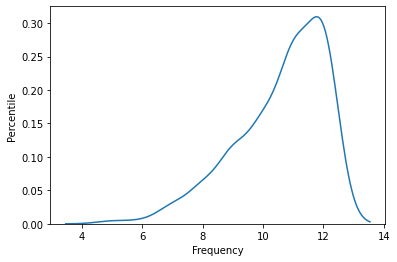

In [ ]:
# we visualize the distribution here 
ax = sns.distplot(keywords_df['genres'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

### **Reformatting the Keywords Dataframe** 

We can now look for the average rating per keyword based on the different movies.


In [ ]:
# Step 1 : create a copy of ratings_df and merge with movies_df
temp_df = ratings_df.copy(deep=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select * from temp_df as t
join movies_df as m on t.movieId = m.id
'''

temp_df = ps.sqldf(query, locals())
temp_df.drop(columns=['id', 'genres', 'popularity','vote_average',\
                      'movieId', 'title'], inplace=True)
temp_df.sort_values(by=['userId'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
temp_df['keywords'] = temp_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

In [ ]:
# Step 2 : append all the keywords as columns 
number_of_rows = temp_df.count()[0]

for keyword in keywords_to_observe:
  temp_df[keyword] = [0 for _ in range(number_of_rows)]

In [ ]:
# Step 3 : assign scores to the columns 
# we again assign a bias score to help differentiate from 0 

bias = 1 
for i in range(number_of_rows):
  keywords = temp_df['keywords'].iat[i]
  val = temp_df['rating'].iat[i]
  for keyword in keywords:  
    if keyword in keywords_to_observe:
      temp_df[keyword].iat[i] += val + bias 

In [ ]:
# Step 4 : create a dataframe similar to genres_df
temp_df.drop(columns=['rating','keywords'], inplace=True)

query = 'select userId,'
for keyword in keywords_to_observe:
  
  query += ' ' + 'avg("' + keyword + '")' + ' as "' + keyword.lower() + '",'
query = query[:-1] + " from temp_df group by userId"

keywords_df = ps.sqldf(query, locals())

### **Correlation within Genre and Keywords** 

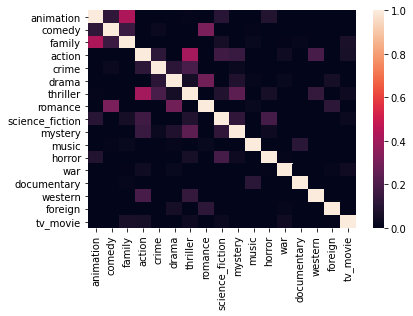

In [ ]:
# check the correlation between genres 
genres_copy = genres_df.drop(columns=['userId'])
sns.heatmap(genres_copy.corr(), vmin=0)

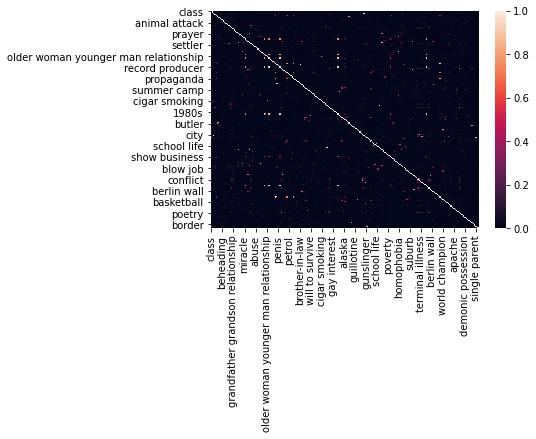

In [ ]:
# check the correlation between keywords
keywords_copy = keywords_df.drop(columns=['userId'])
sns.heatmap(keywords_copy.corr(), vmin=0)

Overall, it seems safe to say that there is not a significant correlation between different genres and keywords. We can now use our dataframe for machine learning. 

### **Building the Final Dataframe** 

In [ ]:
query = '''
select * from genres_df as g
join keywords_df as k on 
g.userId = k.userId   
'''

tmp = ps.sqldf(query, locals())
final_df = tmp.loc[:, ~tmp.columns.duplicated()]

We will use the above dataframe to find a group of users with the most similar preferences to some specified user. We will then recommend the most popular movie among that group of users has seen. If two movies have similar popularity scores (for example, difference of 2 or less), then we will recommend based on vote count.   



In [ ]:
# create a user dataframe to show all movies a user has seen 
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select * 
from ratings_df
join movies_df 
on id = movieId
'''

tmp = ps.sqldf(query, locals())
tmp.drop(columns=['rating','id', 'genres', 'keywords', 'popularity', 'vote_average','title'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 

In [ ]:
curr_user = 1
curr_movies = []
number_of_rows = tmp.count()[0]

all_users = []
all_movies = []

for i in range(number_of_rows):
  if curr_user != tmp['userId'].iat[i]:
    all_users.append(curr_user); all_movies.append(curr_movies)
    curr_user = tmp['userId'].iat[i]; curr_movies = []

  if curr_user == tmp['userId'].iat[i]:
    curr_movies.append(tmp['movieId'].iat[i])

all_users.append(curr_user)
all_movies.append(curr_movies)

In [ ]:
users_df = pd.DataFrame(list(zip(all_users, all_movies)), columns=["userId","movieIds"])

Let's utilize these three dataframes to create a recommendation system : </br>
1. movies_df </br>
2. users_df </br>
3. final_df 
 

In [ ]:
movies_df.head()

,id,title,genres,keywords,popularity,vote_average
0,862,Toy Story,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...",21.946943,7.7
1,8844,Jumanji,"[Adventure, Fantasy, Family]","[board game, disappearance, new home, recluse,...",17.015539,6.9
2,949,Heat,"[Action, Crime, Drama, Thriller]","[robbery, detective, bank, obsession, chase, s...",17.924927,7.7
3,710,GoldenEye,"[Adventure, Action, Thriller]","[cuba, falsely accused, secret identity, compu...",14.686036,6.6
4,1408,Cutthroat Island,"[Action, Adventure]","[exotic island, treasure, map, ship, scalp, pi...",7.284477,5.7


## **Unsupervised Machine Learning with K-Means Clustering**


### **Feeding our data into kMeans Model**



In [ ]:
final_df = final_df.set_index("userId")
final_df.head()

,animation,comedy,family,action,crime,drama,thriller,romance,science_fiction,mystery,music,horror,war,documentary,western,foreign,tv_movie,class,ranch,radio,wave,hairdresser,housekeeper,fanatic,spacecraft,beheading,1930s,animal attack,drugs and addiction,beating,roommate,generations confilct,fog,grandfather grandson relationship,bed,money delivery,sadomasochism,prayer,plastic surgery,difficult childhood,...,city portrait,commune,soul,baby-snatching,mobile phone,tramp,berlin wall,solidarity,art gallery,education,scream,luxury,dictator,melodrama,world champion,train station,basketball,single mother,marshal,midnight movie,rebellion,pub,apache,bounty,camping,battle for power,poetry,classical music,lsd,medicine,demonic possession,motorcycle gang,patient,movie in movie,woods,oklahoma,border,orgasm,single parent,modern society
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.888889,0.000000,0.000000,0.555556,3.222222,0.000000,1.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.666667,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.823529,0.176471,0.882353,0.176471,1.764706,0.470588,0.705882,0.235294,0.411765,0.058824,0.470588,0.176471,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.235294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.000000,0.000000,0.750000,1.000000,2.125000,0.625000,1.250000,0.375000,0.375000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.625000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.850000,0.000000,0.700000,0.850000,1.850000,0.550000,0.950000,0.200000,0.350000,0.000000,0.200000,0.000000,0.0,0.500000,0.05,0.0,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.111111,0.000000,0.666667,1.111111,3.000000,1.222222,1.111111,1.000000,0.555556,0.000000,0.555556,0.000000,0.0,0.444444,0.00,0.0,0.0,0.0,0.666667,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


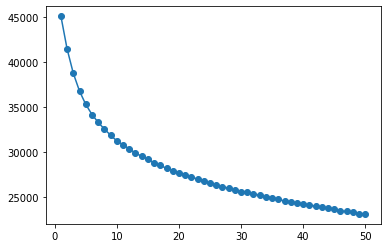

In [ ]:
distortions = []
max_k = 50 

# Find optimal no. of clusters using elbow method
for i in range(1, max_k + 1) :
  km = KMeans(n_clusters = i, 
              init = 'random',
              max_iter = 300,
              random_state = 0)
  km.fit(final_df)
  distortions.append(km.inertia_)

plt.plot(range(1, max_k+1), distortions, marker = 'o')

The result indicates that the optimal number of clusters is quite large, i.e. around 30. This makes sense as we are trying to classify moviegoers, and it makes sense that there are many types of them. Let's use n_clusters = 30. 



In [ ]:
km = KMeans(n_clusters = 30, 
              init = 'random',
              max_iter = 300,
              random_state = 0)
km.fit(final_df)
final_df['cluster'] = km.labels_
final_df[['cluster']].head()

,cluster
userId,
1,1
2,9
3,1
4,9
5,15


### **Making sense of the Clusters**


First, let's take a look at how many users are in each cluster

Text(0.5, 1.0, 'Number of Users in Each Cluster')

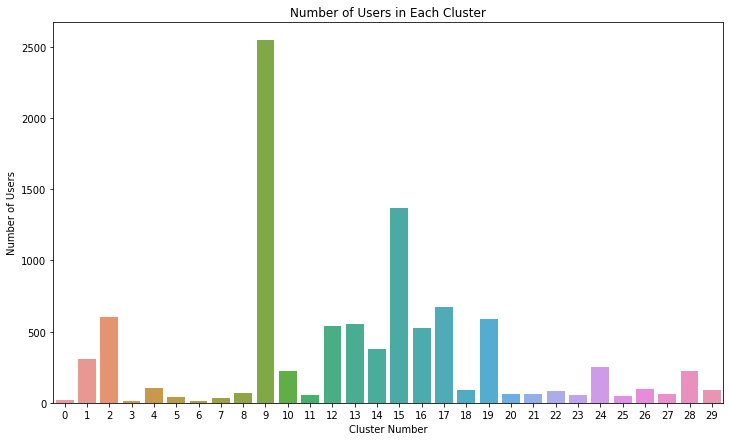

In [ ]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,30,1),y=final_df.groupby(['cluster']).count()['animation'])
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of Users")
axis.set_title("Number of Users in Each Cluster")

Let's see what are the top genre / keyword preferences of users in each cluster


In [ ]:
avg_cluster = final_df.groupby(['cluster']).mean()


max_ratings = np.sort(avg_cluster.iloc[:, :16], axis=1)[:, -3:]

top_genre = []
second_genre = []
third_genre = []

for i in range(len(avg_cluster)):
  top_rating = max_ratings[i, 2]
  enum_rating = enumerate(avg_cluster.loc[i].tolist())
  top_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == top_rating][0]])

  second_rating = max_ratings[i, 1]
  enum_rating = enumerate(avg_cluster.loc[i].tolist())
  if (second_rating == top_rating):
    second_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_rating][1]])
  else:
    second_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_rating][0]])
  
  third_rating = max_ratings[i, 0]
  enum_rating = enumerate(avg_cluster.loc[i].tolist())
  if (third_rating == second_rating):
    third_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_rating][1]])
  else:
    third_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_rating][0]])


avg_cluster['top_genre'] = top_genre
avg_cluster['second_genre'] = second_genre
avg_cluster['third_genre'] = third_genre

# display the top three genres for the first 10 clusters
avg_cluster[['top_genre', 'second_genre', 'third_genre']]

,top_genre,second_genre,third_genre
cluster,,,
0,comedy,drama,thriller
1,drama,comedy,romance
2,drama,comedy,thriller
3,drama,comedy,romance
4,drama,romance,comedy
5,science_fiction,thriller,action
6,drama,mystery,crime
7,horror,comedy,mystery
8,drama,action,war


In [ ]:
avg_cluster = final_df.groupby(['cluster']).mean()

max_keyword_ratings = np.sort(avg_cluster.iloc[:, 16:], axis=1)[:, -3:]

top_keyword = []
second_keyword = []
third_keyword = []

for i in range(len(avg_cluster)):
  top_keyword_rating = max_keyword_ratings[i, 2]
  enum_rating = enumerate(avg_cluster.iloc[i, 16:].tolist())
  top_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == top_keyword_rating][0] + 16])

  second_keyword_rating = max_keyword_ratings[i, 1]
  enum_rating = enumerate(avg_cluster.iloc[i, 16:].tolist())
  if (second_keyword_rating == top_keyword_rating):
    second_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_keyword_rating][1] + 16])
  else:
    second_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_keyword_rating][0] + 16])
  
  third_keyword_rating = max_keyword_ratings[i, 0]
  enum_rating = enumerate(avg_cluster.iloc[i, 16:].tolist())
  if (third_keyword_rating == second_keyword_rating):
    third_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_keyword_rating][1] + 16])
  else:
    third_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_keyword_rating][0] + 16])

avg_cluster['top_keyword'] = top_keyword
avg_cluster['second_keyword'] = second_keyword
avg_cluster['third_keyword'] = third_keyword

# display the top three keywords for the first 10 clusters
avg_cluster[['top_keyword', 'second_keyword', 'third_keyword']]

,top_keyword,second_keyword,third_keyword
cluster,,,
0,relation,wave,self-destruction
1,radio,radio transmission,strong woman
2,world champion,strong woman,relation
3,radio,radio transmission,strong woman
4,petrol,radio,radio transmission
5,spacecraft,relation,beheading
6,dinner,guest,country estate
7,woods,battle for power,fog
8,south africa,prayer,release from prison


### **Finding Most Popular Movies Within Each Cluster**

In [ ]:
# Define a helper function that, given a list of users, outputs the k-th most
# popular movie among the group of users, excluding movies in an 
# excluded_list

def k_most_popular(user_list, k, excluded_list):
  list_of_movies = []

  # pool the movies that the users have watched 
  for user in user_list:
    movie_list = users_df[users_df['userId'] == user]["movieIds"].tolist()[0]
    for movie in movie_list :
      # exclude movies in excluded_list (avoid recommending watched movies)
      if movie not in excluded_list :
        list_of_movies.append(movie)

  # create hash buckets 
  bucket = [[] for _ in range(len(list_of_movies) + 1)]

  # record frequencies and sort according to frequencies 
  Count = collections.Counter(list_of_movies).items()  
  for movie, freq in Count: 
    bucket[freq].append(movie) 
  flat_list = list(itertools.chain(*bucket))

  return flat_list[::-1][:k]


In [ ]:
# Define a helper function that returns a list of users from a certain cluster
def find_users(cluster) :
  return final_df[final_df['cluster'] == cluster].reset_index()['userId'].tolist()

In [ ]:
# Define a helper function that finds the movie name corresponding to a movie ID
def find_movie_name(movie_id) :
  return movies_df[movies_df['id'] == movie_id]['title'].tolist()[0]

Let's try finding the 10 most popular movies within cluster 7. 

Recall that their preferred keywords are "woods", "battle for power", and	"fog".

Their preferred genres are "horror",	"comedy", and	"mystery"

In [ ]:
# Let's try finding the 10 most popular movies within cluster 7 
# Recall that their preferred keywords are "woods", "battle for power", and	"fog"
# Their preferred genres are "horror",	"comedy", and	"mystery"
cluster_users = find_users(7)
for i in k_most_popular(cluster_users, 10, []):
  print(find_movie_name(i))

My Name Is Bruce
Seven Blood-Stained Orchids
Frankenstein Unbound
Begotten
Evil Dead II
Monsoon Wedding
Halloween
Day Watch
The Thing
Sleepless in Seattle


Those do sound like mysterious and horrific movies! Let's do one more with cluster 6.

Recall that their preferred keywords are "dinner",	"guest", and "country estate".

Their preferred genres are "drama",	"mystery", and "crime". 

What kind of movies have these all?

In [ ]:
# Let's try finding the 10 most popular movies within cluster 6 
cluster_users = find_users(6)
for i in k_most_popular(cluster_users, 10, []):
  print(find_movie_name(i))

And Then There Were None
Murder She Said
On Guard
L.A. Confidential
The Gift
Arlington Road
Lucky Number Slevin
The 39 Steps
The Prize


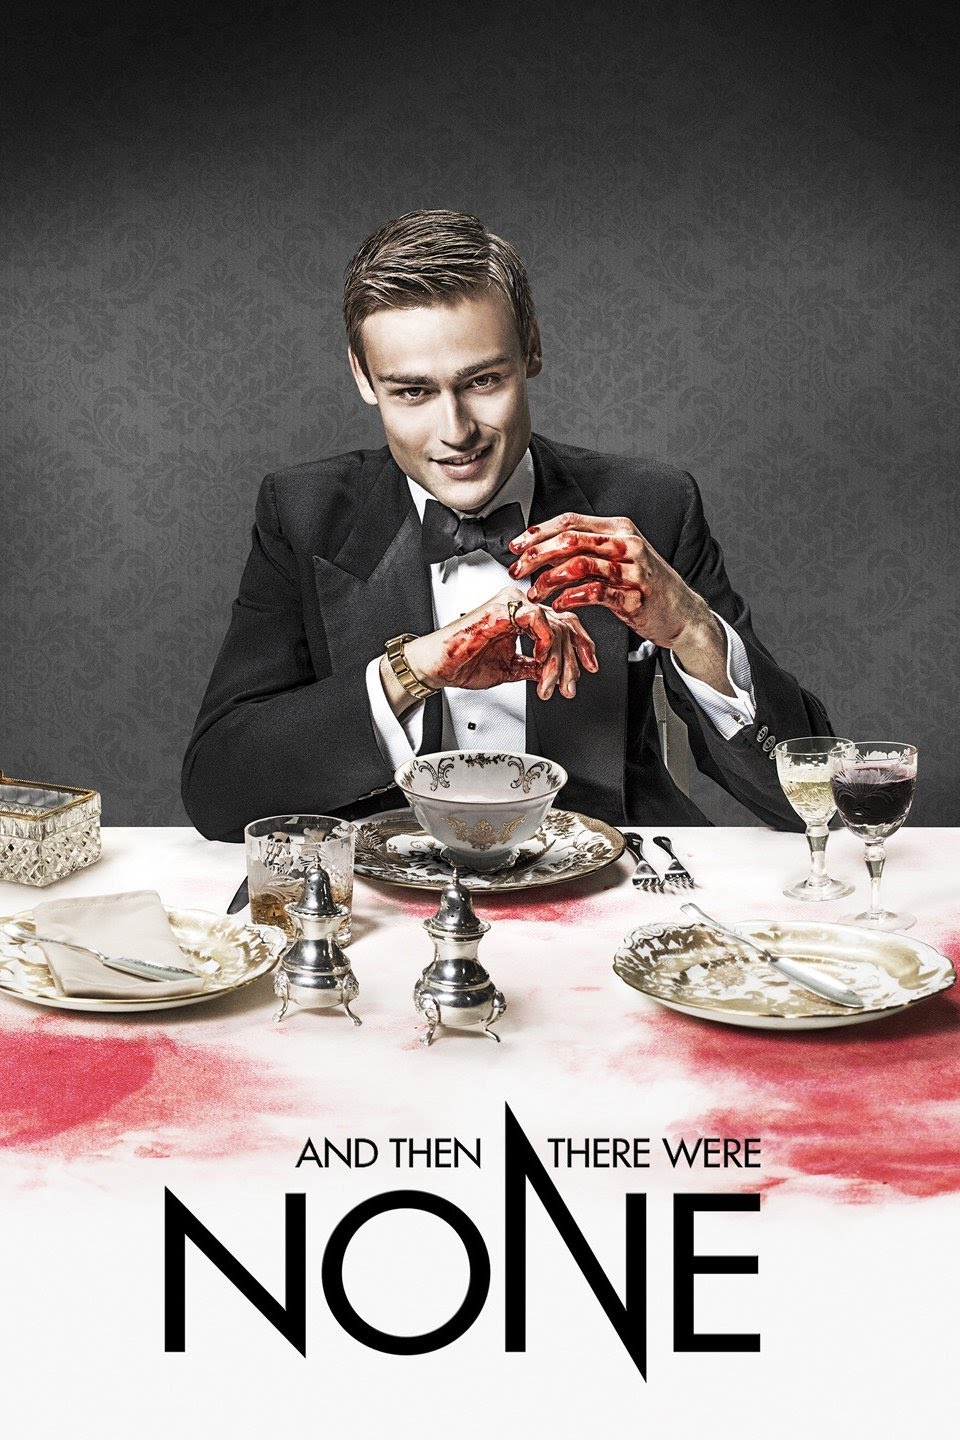

And here comes one of my favorite mystery movies! 

In [ ]:
# Let's try finding the 10 most popular movies within cluster 6 
cluster_users = find_users(15)
for i in k_most_popular(cluster_users, 10, []):
  print(find_movie_name(i))

The Million Dollar Hotel
Solaris
Terminator 3: Rise of the Machines
The 39 Steps
Once Were Warriors
Monsoon Wedding
Sleepless in Seattle
Three Colors: Red
Say Anything...
Sissi


### **Predicting Existing User's Movie Preference**

In [ ]:
# function that recommends a movie to an existing user (in the database)
# the movie would be one that the user hasn't watched
def recommend_movie_existing(existing_user) :

  if (existing_user <= 0) or (existing_user not in users_df['userId']):
    print("invalid user ID entered")
    return

  # find all the users in the same cluster 
  cluster_users = find_users(final_df.iloc[existing_user - 1, :]['cluster'])

  # movies that the user already have watched (we will exclude them)
  users_movie = users_df[users_df['userId'] == existing_user]["movieIds"].tolist()[0]

  print("Movies that the User have watched: \n")

  for i in users_movie:
    print(find_movie_name(i))

  print("\nMovies that we recommend: \n")

  for i in k_most_popular(cluster_users, 5, users_movie) :
    print(find_movie_name(i))

In [ ]:
recommend_movie_existing(5)

Movies that the User have watched: 

Terminator 3: Rise of the Machines
The Man with the Golden Arm
Murder She Said
Sleepless in Seattle
Don't Worry, I'm Fine
Nell
Breakdown
The Curse of Frankenstein
The Searchers

Movies that we recommend: 

The Million Dollar Hotel
Solaris
The 39 Steps
Once Were Warriors
Monsoon Wedding


### **Recommending Movie to New Users**

When we have a new user we'd want to know their current favorite movies in order to give them recommendations. There are too many movies in the data to choose from, so we will just limit ourselves to the most well regarded movies

In [ ]:
## Find the top twenty movies by rating for the new user to choose from
movies_sorted = movies_df.sort_values(by = "vote_average", ascending = False)
# Exclude unpopular movies
movies_sorted = movies_sorted[movies_sorted['popularity'] > 30]
top_twenty = movies_sorted[:20].title

Below is a Dropdown widget that allows you to create a new user by choosing your favorite movies (a subset of the top 20 movies)

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# a list to hold the movies selected by the new user (yes, that means you!)
new_user_movies = []
num_selected = 1

# create dropdown widget
dropdown_movies = widgets.Dropdown(options = top_twenty)


def dropdown_movies_eventhandler(change):
  new_user_movies.append(change.new)

dropdown_movies.observe(dropdown_movies_eventhandler, names='value')

print("Choose Movies From the Below Dropdown List (you can choose multiple)")
display(dropdown_movies)

Choose Movies From the Below Dropdown List (you can choose multiple)


Dropdown(options=('The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Psycho', 'Life Is Beautifu…

In [ ]:
print("Here is the list of Movies you Selected: \n")

for i in new_user_movies:
  print(i)

Here is the list of Movies you Selected: 

Life Is Beautiful
One Flew Over the Cuckoo's Nest
Star Wars
The Matrix


Now that we have a list of favorite movies from our new_user, let's transform this information into input that we can feed in to the kMeans model. Essentially, this means doing what we have done in the data cleaning part: finding the genres and keywords associated with each movie that the user has watched, and adding the user's rating to corresponding columns in the dataframe.

In [ ]:
## Helper function that, given a list of movies that a new user has watched, 
## generate a dataframe in the format of final_df containing just the user's info

def create_new_user(list_of_movies):
  # create new_user df with the same col names as final_df (except cluster)
  new_user = pd.DataFrame(columns = final_df.columns[:-1])
  
  ##TODO 
   
  return new_user 

With what we have got now we can now recommend movies for the new user. Let's see what we get! 

In [ ]:
new_user = create_new_user(new_user_movies)
new_user_cluster = km.predict(new_user)[0]

cluster_users = find_users(new_user_cluster)
recommended = k_most_popular(cluster_users, 10, [])

print("Movies that the User have watched: \n")

for i in new_user_movies:
  print(i)

print("\nMovies that we recommend: \n")

for i in k_most_popular(cluster_users, 5, users_movie) :
  print(find_movie_name(i))

## **Summary**

### **Challenges**

1. Difficulty in validation due to unsupervised nature of ML task
2. Large number of potential features requiring trimming / selecting as well as careful clustering 
3. 

### **Potential Improvements**

1. Try out other clustering methods (e.g. hierarchical)
2. Speed up kMeans clustering convergence by intelligent initialization (not really necessary in this since kMeans is not slow)
3.                                                           